In [6]:
#pip install fitter

In [1]:
import os
import pyodbc
import STG_CBK as bi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn import preprocessing

In [88]:
dataset =  pd.read_sql(sql_sr, bi.conn)
#dataset.head()

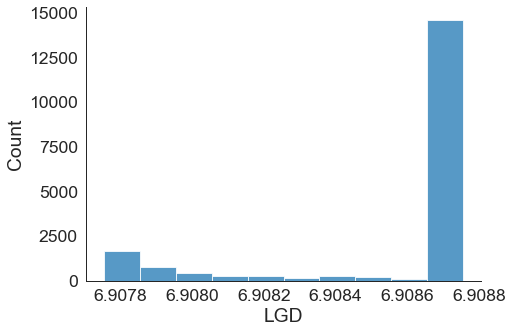

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dataset, x="LGD", kind="hist", bins=10, aspect=1.5)

In [10]:
lgd1 = dataset["LGD"].values

,sumsquare_error,aic,bic,kl_div
beta,4.957880e+09,-968.645047,2.318175e+05,1.334229
norm,5.557175e+09,-1242.136513,2.339144e+05,2.660596
burr,5.660307e+09,-829.572000,2.342751e+05,2.438590
gama,inf,inf,inf,inf
log_normal,inf,inf,inf,inf


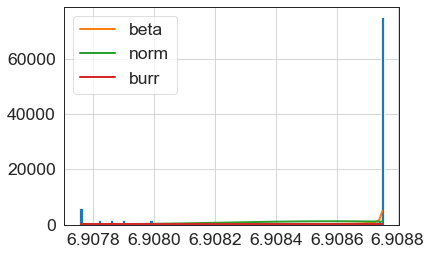

In [11]:
f = Fitter(lgd1,
          distributions=['gama',
                        'log_normal',
                        'beta',
                        'burr',
                        'norm'])
f.fit()
f.summary()

In [26]:
f.get_best(method='sumsquare_error')

{'beta': {'a': 0.16137264901469778,
  'b': 0.035998475742331025,
  'loc': 6.907555447678699,
  'scale': 0.0011993316365215478}}

In [89]:
beta = f.fitted_param["beta"]

In [29]:
a, b, loc, scale = beta[0], beta[1],beta[2],beta[3] 

In [30]:
from scipy import stats
data = stats.beta.rvs(a, b, loc=loc, scale=scale, size=100000)

def promedio(size):
    data =stats.beta.rvs(a, b, loc=loc, scale=scale, size=size)
    m =np.mean(data)
    media = media[m]
    return m

In [31]:
m = []
def promedio(size):
    data =stats.beta.rvs(a, b, loc=loc, scale=scale, size=size)
    m.append(np.mean(data))
    return m

In [32]:
for size in range(1,10000):
    promedio(size)

In [33]:
media_total=np.mean(m)

In [34]:
std_total =np.std(m)

In [35]:
n_total = dataset.shape[0]

In [36]:
intervalo_total = st.t.interval(alpha=0.95, df=len(m)-1, loc = np.mean(m), scale=st.sem(m))

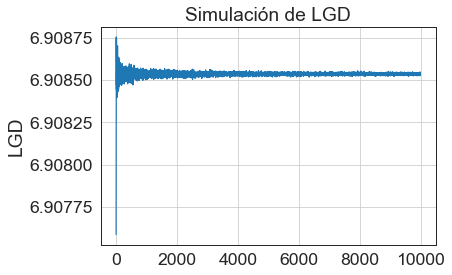

In [37]:
plt.plot(m)
plt.ylabel('LGD')
plt.title('Simulación de LGD')
#plt.text(1000, 0.4, r'Beta(0.046, 0.013, -0.103, 1.103)')
plt.grid(True)

# Calculo de LGD por Portafolio

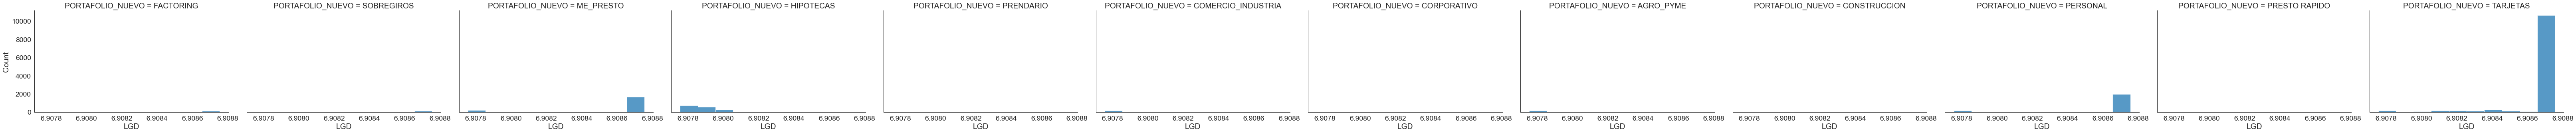

In [38]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dataset, x="LGD", kind="hist", bins=10, aspect=1.5, col='PORTAFOLIO_NUEVO')

In [90]:
portafolio = dataset['PORTAFOLIO_NUEVO'].unique() 

In [40]:
condiciones = [
    (dataset['PORTAFOLIO_NUEVO'] == 'F'), # 1
    (dataset['PORTAFOLIO_NUEVO'] == 'S'), # 2
    (dataset['PORTAFOLIO_NUEVO'] == 'M'),  # 3
    (dataset['PORTAFOLIO_NUEVO'] == 'H'),  # 4
    (dataset['PORTAFOLIO_NUEVO'] == 'CI'), # 5
    (dataset['PORTAFOLIO_NUEVO'] == 'C'),        # 6
    (dataset['PORTAFOLIO_NUEVO'] == 'A'),          # 7
    (dataset['PORTAFOLIO_NUEVO'] == 'CO'),       # 8
    (dataset['PORTAFOLIO_NUEVO'] == 'P'),           # 9
    (dataset['PORTAFOLIO_NUEVO'] == 'PR'),      # 10
    (dataset['PORTAFOLIO_NUEVO'] == 'T')]           # 11
eleccion = ['1', '2', '3', '4' ,'5','6','7','8','9','10','11']
dataset['cod_portafolio'] = np.select(condiciones, eleccion)

In [41]:
#dataset
#dataset['cod_portafolio']==0
dataset['cod_portafolio'].unique()

array(['1', '2', '3', '4', '0', '5', '6', '7', '8', '9', '10', '11'],
      dtype=object)

In [86]:
#dataset.groupby(['PORTAFOLIO_NUEVO']).size()

In [43]:
for i in dataset['cod_portafolio'].unique():
    locals()['data' + i] = dataset.loc[(dataset.cod_portafolio == i), 'LGD']

In [44]:
# Solo usar la primera vez
parametros = {'distribucion' : ['distr'],
              #'t':0,
              'n': 0,
              'a': 0,
              'b': 0,
              #'c': 0,
              'locale': 0,
              'scale': 0}
df = pd.DataFrame( data = parametros)
df

,distribucion,n,a,b,locale,scale
0,distr,0,0,0,0,0


In [70]:
data_modelar = [data12]
                #data0, data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11]
for i in data_modelar:
    min_max_scaler = preprocessing.MinMaxScaler()
    data_minmax = min_max_scaler.fit_transform(i.values.reshape(-1,1))
    f = Fitter(data_minmax,
              distributions=['gama','log_normal', 'beta','burr', 'norm', 'weibull'])
    f.fit()
   #f.summary()
    best_model = f.get_best(method='sumsquare_error')
    print(best_model)  

NameError: name 'data12' is not defined

In [85]:
for key in best_model:
  #print (key, ":", z[key])
  list = [key]
  list.append(best_model[key])
  distr =list[0]
  a= list[1]['a']
  b= list[1]['b']
  #c= list[1]['c']
  locale= list[1]['loc']
  scale= list[1]['scale']
 # skew = list[1]['skew']
  n = len(data_modelar[0])

parametros = {'distribucion' : distr, 'n':n ,'a': a, 'b': b,'locale': locale, 'scale':scale}
#parametros
df = df.append(parametros, ignore_index=True)

In [84]:
#df =df.drop([0])

In [73]:
df_beta =df[df['distribucion'] == "beta"]
simulacion = []
for i in range(df_beta.shape[0]):
    for size in range(1,1000):
        a, b, loc, scale = df_beta.iloc[i,2],df_beta.iloc[i,3], df_beta.iloc[i,4], df_beta.iloc[i,5]
        data =st.beta.rvs(a, b, loc=loc, scale=scale, size=size)
        prom = np.mean(data)
        inter = st.t.interval(alpha=0.95, df=len(data)-1, loc = np.mean(data), scale=st.sem(data))
        simulacion.append(
            {'muestra': i, 
             'media':prom ,
             'lim_inf': inter[0], 
             'lim_sup': inter[1]}
        )
        simulacion1 = pd.DataFrame(simulacion)

In [74]:
intervalo_media =[]
for i in range(df_beta.shape[0]):
    k = simulacion1.loc[simulacion1.loc[:,'muestra']==i]['media']
    intervalo_m =st.t.interval(alpha=0.95, df=len(k)-1, 
                               loc = np.mean(k), 
                               scale=st.sem(k))
    intervalo_media.append (
        {
             'modelo': i, 
             'lim_inf': intervalo_m[0], 
             'lim_sup': intervalo_m[1]
        }
    )
    intervalo_media1 =pd.DataFrame(intervalo_media)

In [75]:
df_resu1 = pd.concat([simulacion1.groupby('muestra')['media'].mean(),
            simulacion1.groupby('muestra')['media'].std()],
          axis = 1)

In [82]:
df_resu1.columns = ['media', 'std']
df_resu2 =pd.concat([intervalo_media1,df_resu1], axis = 1)
df_resu2.index = df_beta.index.to_list()
df_resu3 = pd.concat([df_beta, df_resu2], axis= 1)
#df_resu3

In [79]:
df_burr =df[df['distribucion'] == "burr"]
simulacion_b = []
for i in range(df_burr.shape[0]):
    for size in range(1,1000):
        c, d,loc, scale = df_burr.iloc[i,2], df_burr.iloc[i,3],df_burr.iloc[i,4], df_burr.iloc[i,5]
        data =st.burr.rvs(c, d, loc=loc, scale=scale, size=size)
        prom = np.mean(data)
        inter = st.t.interval(alpha=0.95, df=len(data)-1, loc = np.mean(data), scale=st.sem(data))
        simulacion_b.append(
            {'muestra': i, 
             'media':prom ,
             'lim_inf': inter[0], 
             'lim_sup': inter[1]}
        )
        simulacion_b1 = pd.DataFrame(simulacion_b)

In [80]:
intervalo_media_b =[]
for i in range(df_burr.shape[0]):
    k = simulacion_b1.loc[simulacion_b1.loc[:,'muestra']==i]['media']
    intervalo_bm =st.t.interval(alpha=0.95, df=len(k)-1, 
                               loc = np.mean(k), 
                               scale=st.sem(k))
    intervalo_media_b.append (
        {
             'modelo': i, 
             'lim_inf': intervalo_bm[0], 
             'lim_sup': intervalo_bm[1]
        }
    )
    intervalo_media_b1 =pd.DataFrame(intervalo_media_b)

In [81]:
df_resu_b1 = pd.concat([simulacion_b1.groupby('muestra')['media'].mean(),
            simulacion_b1.groupby('muestra')['media'].std()],
          axis = 1)
df_resu_b1.columns = ['media', 'std']
df_resu_b2 =pd.concat([intervalo_media_b1,df_resu_b1], axis = 1)
df_resu_b2.index = df_burr.index.to_list()
df_resu_b3 = pd.concat([df_burr, df_resu_b2], axis= 1)
df_resultado = pd.concat([df_resu3, df_resu_b3])